# Class Prediction
+ author: Gaurav Modi
+ date: 
+ date: 2018-01-20 15:20
+ Modified: 2018-01-20 21:20
+ description: "How to train a deep convolutional neural network with Keras in Python." 
+ tags: sklearn, prediction, classification

# Car Evaluation Data Set 

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import graphviz
import seaborn as sns
%matplotlib inline

5. Number of Instances: 1728
   (instances completely cover the attribute space)

6. Number of Attributes: 6

7. Attribute Values:
buying       v-high, high, med, low
   
   maint        v-high, high, med, low
   
   doors        2, 3, 4, 5-more
   
   persons      2, 4, more
   
   lug_boot     small, med, big
   
   safety       low, med, high

In [181]:
def read_data(dtype='nominal'):
    df = pd.read_csv("data/car.data.csv", header=None,
                     names=['buying_price','maintain_price','doors',
                            'passenger_capacity','boot_size',
                            'safety_rating', 'evaluation'],
                     index_col=False)
    if dtype == 'numeric':
        df.doors = np.where(df.doors == '5more', 5, df.doors).astype(int)
        df.passenger_capacity = np.where(df.passenger_capacity == 'more', 5, df.passenger_capacity).astype(int)
    return df

def get_Xy(dtype='nominal'):
    df = read_data(dtype)
    return df.iloc[:, :-1], df.evaluation

def get_test_train(dtype='nominal', test_size=0.3, seed=42):
    X, y = get_Xy(dtype)
    return train_test_split(X, y, test_size=test_size, random_state=seed)
    #return X_train, X_test, y_train, y_test
    
def reverse_encode(y):
    label_encoding_dict = {2:'unacc', 0: 'acc', 1:'good', 3: 'vgood'}    
    return y.map(label_encoding_dict)

In [182]:
df = read_data()

In [183]:
df.head()

,buying_price,maintain_price,doors,passenger_capacity,boot_size,safety_rating,evaluation
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### Checking for Missing Values

In [184]:
df.doors.value_counts()

3        432
5more    432
4        432
2        432
Name: doors, dtype: int64

In [185]:
df.passenger_capacity.value_counts()

more    576
4       576
2       576
Name: passenger_capacity, dtype: int64

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying_price          1728 non-null object
maintain_price        1728 non-null object
doors                 1728 non-null object
passenger_capacity    1728 non-null object
boot_size             1728 non-null object
safety_rating         1728 non-null object
evaluation            1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In [187]:
df.isnull().any()

buying_price          False
maintain_price        False
doors                 False
passenger_capacity    False
boot_size             False
safety_rating         False
evaluation            False
dtype: bool

#### No missing or null values found in any of the attributes.

In [188]:
df.dtypes

buying_price          object
maintain_price        object
doors                 object
passenger_capacity    object
boot_size             object
safety_rating         object
evaluation            object
dtype: object

### Response Variable distribution

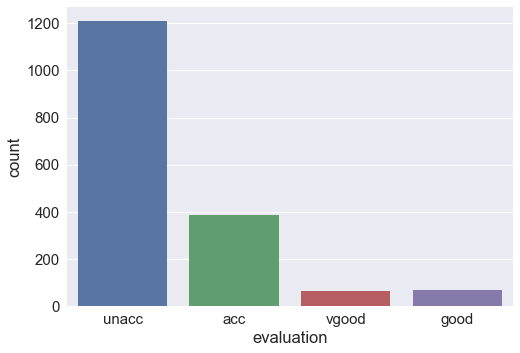

In [189]:
df_orig = read_data()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.countplot(x="evaluation", data=df_orig)

Data is skewed and we have very few samples of 'vgood' and 'good' evaluation. Accuaracy will not be a good indicator of how well our model is working. <p> Therefore, to measure performance of different models, I will use f-measure to compare different model performance.</p>

## 1. Decision Tree

### Splitting Test and train data in 70-30 ratio.

As our data is skewed, we should stratified sampling. <p> train_test_split() function of sci-kit learn do stratified splitting by default.

In [190]:
df = read_data()
encoder_dict = dict()
for column in df.columns:
    if df[column].dtype == type(object):
        encoder_dict[column] = LabelEncoder()
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        
X, y = df.iloc[:, :-1], df.evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Grid Search for finding optimal hyper parameters

In [191]:
criterion = ['gini','entropy']
splitter = ['best','random']
max_depth = list(range(1,50))
min_sample_lead = list(range(1, 50))

param_grid = dict(max_depth=max_depth, criterion=criterion, splitter = splitter)
scores = ['accuracy']
dt = tree.DecisionTreeClassifier()
for score in scores:
    grid_dt=GridSearchCV(dt, param_grid, cv=10,scoring=score, n_jobs= 4)
    print("Optimizing parameters for %s" % score)
    grid_dt.fit(X_train,y_train)
    print(grid_dt.best_params_)
    print(np.round(grid_dt.best_score_,3))

Optimizing parameters for accuracy
{'splitter': 'best', 'criterion': 'entropy', 'max_depth': 10}
0.983


In [192]:
dt = tree.DecisionTreeClassifier(splitter='best', criterion='entropy', max_depth=10)
dt = dt.fit(X_train, y_train)

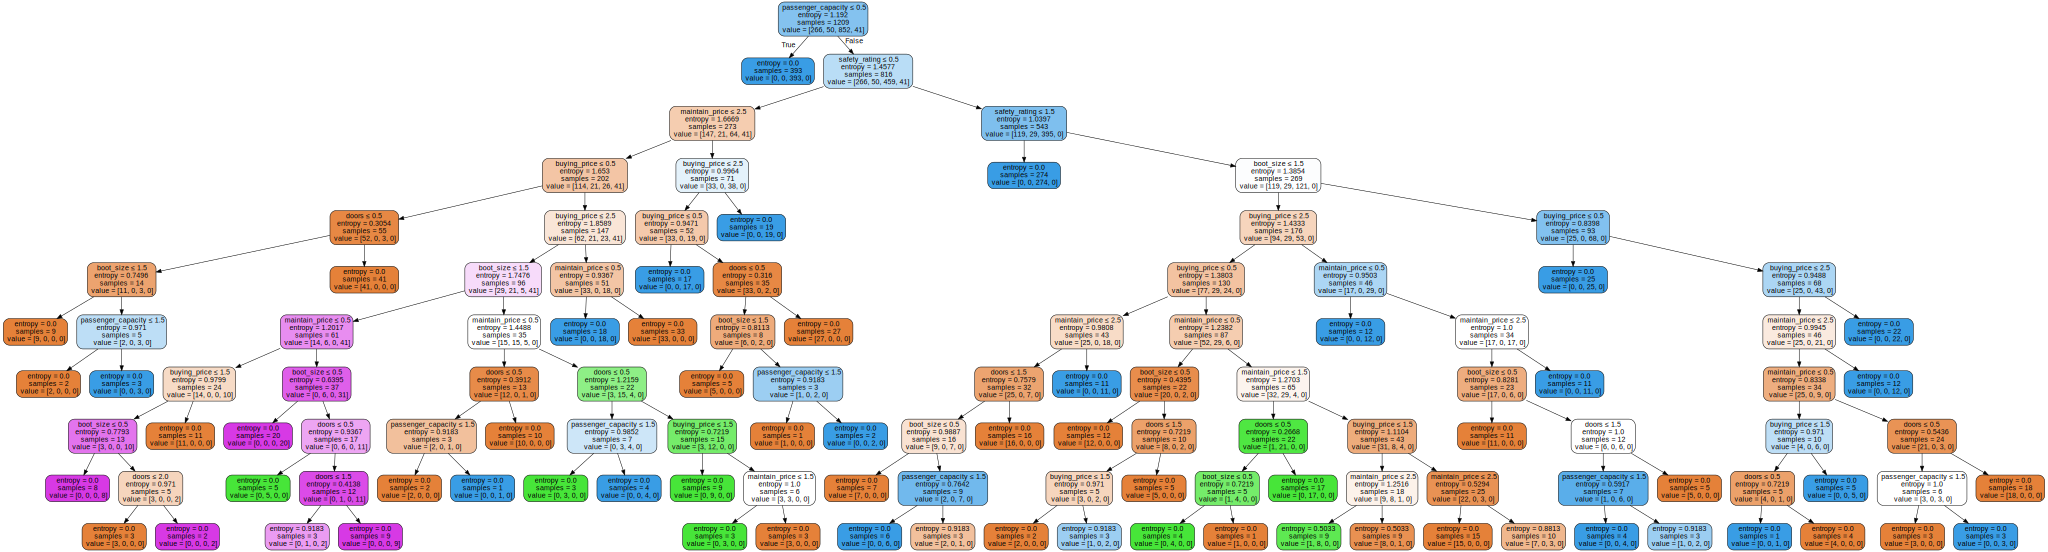

In [193]:
feature_names = X_train.columns
dot_data = tree.export_graphviz(dt, out_file=None,
                                feature_names=feature_names,
                                filled=True, rounded=True, 
                                special_characters=True)

graph = graphviz.Source(dot_data)
# graph.render("dt_v1") 
# graph

In [194]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print classification_report(y_test, y_pred, target_names=['unacc', 'acc', 'good', 'vgood'])

             precision    recall  f1-score   support

      unacc       0.92      0.93      0.92       118
        acc       0.71      0.89      0.79        19
       good       0.99      0.98      0.99       358
      vgood       0.90      0.79      0.84        24

avg / total       0.96      0.96      0.96       519



In [195]:
print 'Accuracy: {0}'.format(accuracy_score(y_true=y_test, y_pred=y_pred))
print '\n'
print 'Confusion Matrix'

c_m = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matrix = pd.DataFrame(c_m, 
                           columns=[ 'Predicted acc', 'Predicted good', 'Predicted unacc', 'Predicted vgood'],
                           index=['Actual acc', 'Actual good', 'Actual unacc', 'Actual vgood'])
conf_matrix

Accuracy: 0.959537572254


Confusion Matrix


,Predicted acc,Predicted good,Predicted unacc,Predicted vgood
Actual acc,110,5,2,1
Actual good,1,17,0,1
Actual unacc,6,0,352,0
Actual vgood,3,2,0,19


## 2. k-NN Classifier

The optimal value for k for weight='uniform' is: 5 with error rate of: 0.0927
The optimal value for k for weight='distance' is: 7 with error rate of: 0.0902


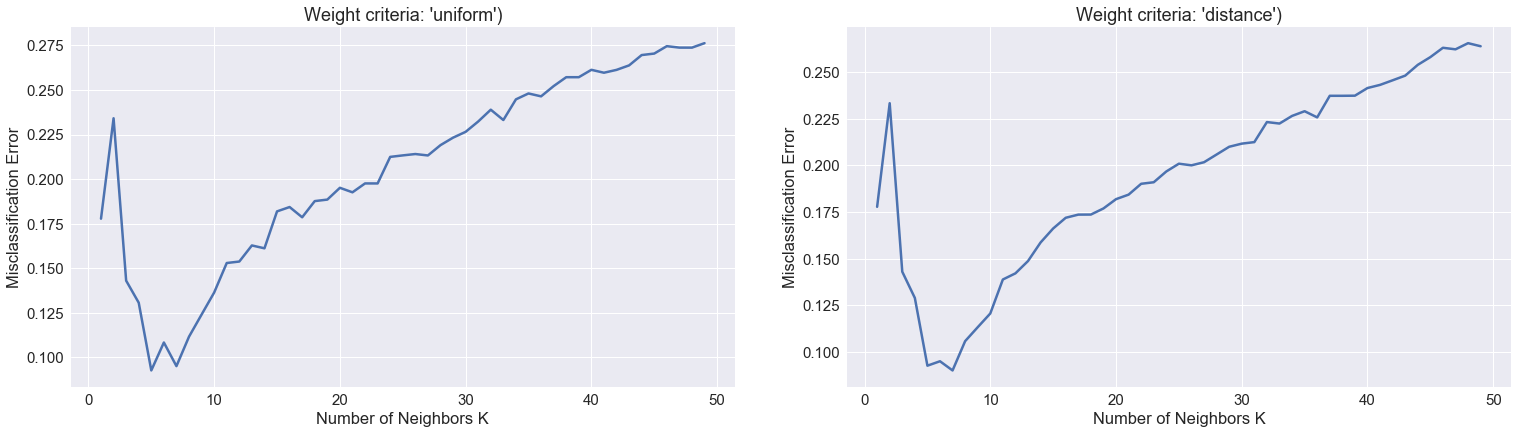

In [196]:
cv_scores = list()

neighbors = list(range(1,50))
plt.figure(figsize=(10,5))

i = 1
for weights in ['uniform', 'distance']:
    cv_scores = list()
    for k in neighbors:
        knn= KNeighborsClassifier(n_neighbors=k, weights=weights)
    #Cross Validation
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
        
#Plotting the Error rate        
    error = [1 - x for x in cv_scores]
    k_optimal = neighbors[error.index(min(error))]
    print "The optimal value for k for weight='{0}' is: {1} with error rate of: {2}".format(weights, k_optimal, round(min(error),4))

    plt.subplot(1,2,i)
    plt.tight_layout()
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.title("Weight criteria: '%s')"
              % (weights))
    plt.subplots_adjust(left=1.5, bottom=0.5, right=3.5, top=1.5)
    plt.plot(neighbors, error)
    i = i + 1
plt.show()  

### - The optimal value for k for weight='uniform' is: 5 with error rate of: 0.0927
### - The optimal value for k for weight='distance' is: 7 with error rate of: 0.0902

In [197]:
knn= KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print classification_report(y_test, y_pred, target_names=['unacc', 'acc', 'good', 'vgood'])

             precision    recall  f1-score   support

      unacc       0.91      0.77      0.83       118
        acc       0.93      0.74      0.82        19
       good       0.93      0.99      0.96       358
      vgood       0.91      0.88      0.89        24

avg / total       0.93      0.93      0.92       519



In [203]:
print 'Accuracy: {0}'.format(accuracy_score(y_true=y_test, y_pred=y_pred))
print '\n'
print 'Confusion Matrix'

c_m = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matrix = pd.DataFrame(c_m, 
                           columns=[ 'Predicted acc', 'Predicted good', 'Predicted unacc', 'Predicted vgood'],
                           index=['Actual acc', 'Actual good', 'Actual unacc', 'Actual vgood'])
conf_matrix

Accuracy: 0.666666666667


Confusion Matrix


,Predicted acc,Predicted good,Predicted unacc,Predicted vgood
Actual acc,22,0,96,0
Actual good,2,0,17,0
Actual unacc,34,0,324,0
Actual vgood,14,0,10,0


## 3. Logistic Regression

In [199]:
logit = LogisticRegression(multi_class='ovr')
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)

In [200]:
print classification_report(y_test, y_pred, target_names=['unacc', 'acc', 'good', 'vgood'])

             precision    recall  f1-score   support

      unacc       0.31      0.19      0.23       118
        acc       0.00      0.00      0.00        19
       good       0.72      0.91      0.80       358
      vgood       0.00      0.00      0.00        24

avg / total       0.57      0.67      0.61       519



In [201]:
print 'Accuracy: {0}'.format(accuracy_score(y_true=y_test, y_pred=y_pred))
print '\n'
print 'Confusion Matrix'

c_m = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matrix = pd.DataFrame(c_m, 
                           columns=[ 'Predicted acc', 'Predicted good', 'Predicted unacc', 'Predicted vgood'],
                           index=['Actual acc', 'Actual good', 'Actual unacc', 'Actual vgood'])
conf_matrix

Accuracy: 0.666666666667


Confusion Matrix


,Predicted acc,Predicted good,Predicted unacc,Predicted vgood
Actual acc,22,0,96,0
Actual good,2,0,17,0
Actual unacc,34,0,324,0
Actual vgood,14,0,10,0


Decision Tree is performing best here. The accuracy we are getting here with decision tree is ~0.96 and average f-score is also 0.96, highest among all models.
Here I'm treating variable: Number of doors and number of passengers as nominal data as we don't have actual value of both these variables are more than 4. Therefore, I'm using both these variable as nominal.